Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free under certain conditions — see the [`license`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

In [102]:
import logging
import random
from itertools import accumulate
from itertools import combinations
import pandas as pd
import geopy.distance
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
import numpy as np

from icecream import ic



## Lab2 - TSP

https://www.wolframcloud.com/obj/giovanni.squillero/Published/Lab2-tsp.nb

In [101]:
cities = pd.read_csv('cities/russia.csv', header=None, names=['name', 'lat', 'lon'])
cities

,name,lat,lon
0,Abakan,53.72,91.4300
1,Achinsk,56.28,90.5000
2,Almetyevsk,54.90,52.3100
3,Angarsk,52.57,103.9100
4,Arkhangelsk,64.57,40.5300
...,...,...,...
162,Yuzhno‐Sakhalinsk,46.95,142.7400
163,Zelenograd,55.94,37.2900
164,Zheleznodorozhnyy,55.75,38.0167
165,Zhukovskiy,55.55,38.2500


In [103]:
dist_matrix = np.zeros((len(cities), len(cities)))
for c1, c2 in combinations(cities.itertuples(), 2):
    dist_matrix[c1.Index, c2.Index] = dist_matrix[c2.Index, c1.Index] = geopy.distance.geodesic(
        (c1.lat, c1.lon), (c2.lat, c2.lon)
    ).km


## GREEDY SOLUTION PROPOSED BY THE PROFESSOR AS A STARTING POINT

In [ ]:

visited = np.full(len(cities), False)
dist = dist_matrix.copy()
city = 0
visited[city] = True
tsp = list()
tsp.append(int(city))
while not np.all(visited):
    dist[:, city] = np.inf
    closest = np.argmin(dist[city])
    logging.debug(
        f"step: {cities.at[city,'name']} -> {cities.at[closest,'name']} ({dist_matrix[city,closest]:.2f}km)"
    )
    visited[closest] = True
    city = closest
    tsp.append(int(city))
logging.debug(
    f"step: {cities.at[tsp[-1],'name']} -> {cities.at[tsp[0],'name']} ({dist_matrix[tsp[-1],tsp[0]]:.2f}km)"
)
tsp.append(tsp[0])

tot_cost = 0
for c1, c2 in zip(tsp, tsp[1:]):
    tot_cost += dist_matrix[c1, c2]
logging.info(f"result: Found a path of {len(tsp)-1} steps, total length {tot_cost:.2f}km")

## Helping Functions

In [ ]:

def inversion_mutation(individual):
    newsol = individual.genome[:]
    i, j = sorted(random.sample(range(1, len(newsol) - 1), 2))
    newsol[i:j] = reversed(newsol[i:j])
    return Individual(newsol)

def fitness(sol):
    tot_cost = 0
    for c1, c2 in zip(sol, sol[1:]):
        tot_cost += dist_matrix[c1, c2]
    return -float(tot_cost)

class Individual:
    def __init__(self, genome, fitness=0):
        self.genome = genome
        self.fitness = fitness   
     
#instead of a random parent selection we use an "elitist selection" where we choose 2 individuals between the best 10
def elitist_selection(population, elite_size=10):
    elites = sorted(population, key=lambda x: x.fitness, reverse=True)[:elite_size]
    return np.random.choice(elites)

def inver_over_xover(s1, s2):
    first = s1[0]
    S1 = s1[1:len(s1)-1]
    S2 = s2[1:len(s1)-1]
    start = random.randint(0, len(S1) - 2)
    end = random.randint(start + 1, len(S1) - 1)
    child = S1[start:end + 1]
    for gene in S2:
        if gene not in child:
            child.append(gene)
    child.insert(0, first)
    child.insert(len(s1), first)
    individual = Individual(child)
    
    return individual

#i generate a random permutation of integers representing a sequence of cities
#first indicate the starting city (the same in all the solutions)
def generate_individual(first, l):
    vector = np.random.permutation([i for i in range(l) if i != first])
    individual = vector.tolist()
    individual.insert(0, first)
    individual.insert(l, first)
    guy = Individual(individual)
    return guy


## EA with inverover xover and inversion mutation

In [ ]:
MAX_STEPS = 1000
POPULATION_SIZE = 300
#the "grandfather" is the best solution found with the greedy algorithm, it will probably be the fittest in the first generation
grandfather = Individual(tsp)
grandfather.fitness = fitness(tsp)
first = tsp[0]
population = [grandfather]

#initialization
for _ in range(1, POPULATION_SIZE):
    individual = generate_individual(first, len(cities))
    individual.fitness = fitness(individual.genome)
    population.append(individual)

OFFSPRING_SIZE = 25

#for usa and china are recommended 20000 and 40000 generations or more
MAX_GENERATIONS = 10000

for g in tqdm(range(MAX_GENERATIONS)):
    offspring = list()
    for _ in range(OFFSPRING_SIZE):
        if np.random.random() < .4:
            p = elitist_selection(population)
            o = inversion_mutation(p)
        else:
            p1 = elitist_selection(population)
            p2 = elitist_selection(population)
            o = inver_over_xover(p1.genome, p2.genome)
            if np.random.random() < 0.2:
                o = inversion_mutation(o)
        offspring.append(o)
    for i in offspring:
        i.fitness = fitness(i.genome)
    
    population.extend(offspring)
    population.sort(key=lambda i: i.fitness, reverse=True)
    population = population[:POPULATION_SIZE]
    ic(population[0].fitness)

population[0].genome, population[0].fitness
        




  0%|          | 0/10000 [00:00<?, ?it/s]

ic| population[0].fitness: -42334.16465744784
ic| population[0].fitness: -42334.16465744784
ic| population[0].fitness: -42334.16465744784
ic| population[0].fitness: -42334.16465744784
ic| population[0].fitness: -42334.16465744784
ic| population[0].fitness: -42334.16465744784
ic| population[0].fitness: -42334.16465744784
ic| population[0].fitness: -42334.16465744784
ic| population[0].fitness: -42334.16465744784
ic| population[0].fitness: -42334.16465744784
ic| population[0].fitness: -42334.16465744784
ic| population[0].fitness: -42334.16465744784
ic| population[0].fitness: -42334.16465744784
ic| population[0].fitness: -42334.16465744784
ic| population[0].fitness: -42334.16465744784
ic| population[0].fitness: -42334.16465744784
ic| population[0].fitness: -42334.16465744784
ic| population[0].fitness: -42334.16465744784
ic| population[0].fitness: -42334.16465744784
ic| population[0].fitness: -42334.16465744784
ic| population[0].fitness: -42334.16465744784
ic| population[0].fitness: -42334.

([0,
  54,
  1,
  124,
  139,
  40,
  58,
  109,
  86,
  15,
  11,
  90,
  113,
  97,
  137,
  142,
  55,
  49,
  20,
  65,
  166,
  36,
  159,
  105,
  79,
  104,
  33,
  74,
  70,
  77,
  2,
  96,
  143,
  131,
  117,
  62,
  101,
  91,
  100,
  99,
  118,
  85,
  138,
  134,
  9,
  120,
  29,
  37,
  155,
  153,
  152,
  125,
  89,
  84,
  112,
  135,
  12,
  28,
  8,
  24,
  38,
  63,
  42,
  30,
  73,
  149,
  72,
  111,
  45,
  22,
  76,
  130,
  5,
  64,
  128,
  53,
  88,
  13,
  129,
  56,
  102,
  18,
  34,
  110,
  147,
  127,
  35,
  94,
  122,
  108,
  95,
  66,
  43,
  163,
  141,
  121,
  150,
  98,
  27,
  81,
  126,
  50,
  69,
  10,
  164,
  60,
  165,
  46,
  114,
  87,
  140,
  160,
  156,
  59,
  136,
  103,
  119,
  145,
  25,
  39,
  161,
  83,
  19,
  80,
  26,
  7,
  68,
  52,
  32,
  51,
  158,
  115,
  154,
  21,
  148,
  47,
  116,
  107,
  67,
  123,
  4,
  133,
  44,
  14,
  75,
  132,
  78,
  93,
  92,
  82,
  157,
  61,
  106,
  162,
  48,
  41,
  71,
  

## RMHC

  0%|          | 0/1000 [00:00<?, ?it/s]

(-35176.446385535004, -42334.16465744784)

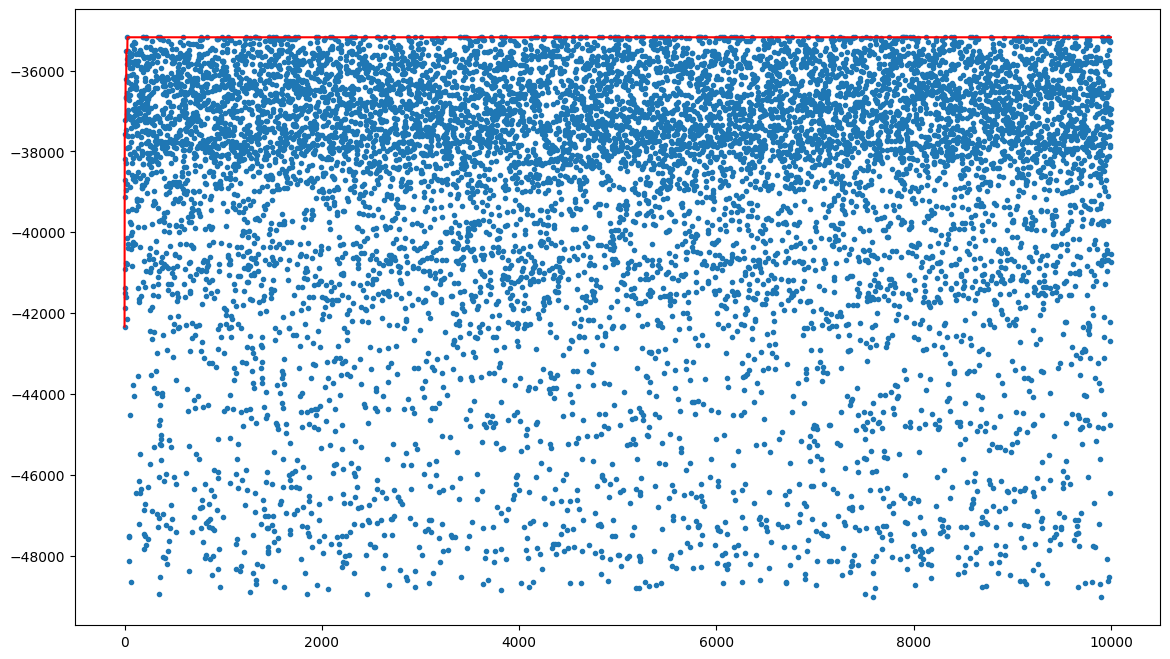

In [ ]:
STEPS = 1000
bestsolution = Individual(tsp)
f = fitness(bestsolution.genome)
history = [f]
for i in tqdm(range(STEPS)):   
    for _ in range(10):
        new_solution = inversion_mutation(Individual(current_solution)).genome
        new_fitness = fitness(new_solution)
        history.append(new_fitness)

        if new_fitness > current_fitness:
            current_solution = new_solution
            current_fitness = new_fitness

            if new_fitness > best_fitness:
                best_solution = new_solution
                best_fitness = new_fitness
            
plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")

fitness(best_solution), fitness(tsp)